# **Da Fare**
## Far rigirare le matrici di confusione

#Classification


In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import pydotplus
from sklearn import tree
from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sn
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [60]:
df_rf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HR_Analytics/csv/HR_Analytics_DBScan.csv', delimiter=',', skipinitialspace=True)
df_target = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HR_Analytics/csv/HR_Analytics.csv', delimiter=',', skipinitialspace=True)
df_rf['target']=df_target['target'].copy()
df_cont = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HR_Analytics/csv/HR_Analytics_KMeans.csv', delimiter=',', skipinitialspace=True)

In [61]:
categ_columns = ['gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'company_size', 'company_type']
num_columns = ['city_development_index', 'experience', 'last_new_job', 'training_hours']
df = pd.DataFrame()

In [62]:
df[num_columns] = df_cont[num_columns] #siccome abbiamo sistemato le variabili numeriche e quelle categoriche in istanze separate, ho dovuto riunirle
df_dummies = pd.get_dummies(df_rf[categ_columns], prefix_sep='=') #per le categoriche ci servono sempre i dummies
df[df_dummies.columns] = df_dummies
df['target']=df_target['target'].copy() #nel clustering avevamo tolgo la variabile target e invece qui ci serve

In [6]:
df.head()

,city_development_index,experience,last_new_job,training_hours,gender=Female,gender=Male,gender=Other,relevent_experience=Has relevent experience,relevent_experience=No relevent experience,enrolled_university=Full time course,enrolled_university=Part time course,enrolled_university=no_enrollment,education_level=Graduate,education_level=High School,education_level=Masters,education_level=Phd,education_level=Primary School,major_discipline=Arts,major_discipline=Business Degree,major_discipline=Humanities,major_discipline=No Discipline,major_discipline=No Major,major_discipline=Other,major_discipline=STEM,company_size=10/49,company_size=100-500,company_size=1000-4999,company_size=10000+,company_size=50-99,company_size=500-999,company_size=5000-9999,company_size=<10,company_type=Early Stage Startup,company_type=Funded Startup,company_type=NGO,company_type=Other,company_type=Public Sector,company_type=Pvt Ltd,target
0,0.920,25.0,1,36,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1.0
1,0.776,15.0,5,47,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0.0
2,0.624,5.0,0,83,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0.0
3,0.789,0.5,0,52,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1.0
4,0.767,25.0,4,8,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0.0


In [7]:
len(df[df['target']==0])/len(df['target']), len(df[df['target']==1])/len(df['target'])  

(0.7506524689424784, 0.24934753105752167)

In [63]:
attributes = [col for col in df.columns if col != 'target']
X = df[attributes].values 
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=100, 
                                                    stratify=y) #solita suddivisione in test e train che useremo per tutti i classificatori

In [ ]:
#scaler = MinMaxScaler()
#scaler.fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

#Decision Tree

Inizializziamo un'istanza del Decision Tree per fare Parameter tuning e capire quali sono i parametri "migliori" per max_depth, min_samples_split, min_samples_leaf.

In [9]:
dtree = DecisionTreeClassifier() #definisco il tipo di classificatore

In [10]:
def report(results, n_top=3): #questa è solo una funzione che mi mostra in modo carino i risultati del RandomSearch
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [11]:
#lista dei valori tra cui saranno variati i nostri parametri durante il random search
param_list = {'max_depth': [None] + list(np.arange(2, 20)),
              'min_samples_split': [2, 5, 10, 20, 30, 50, 100],
              'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100],
              'criterion': ['gini', 'entropy']
               }

In [12]:
dtree_grid_search = GridSearchCV(dtree, param_grid=param_list, 
                                   cv=5, scoring='f1')
dtree_grid_search.fit(X_train, y_train)
dtree = dtree_grid_search.best_estimator_
report(dtree_grid_search.cv_results_, n_top=3)

Model with rank: 1
Mean validation score: 0.493 (std: 0.015)
Parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 100}

Model with rank: 2
Mean validation score: 0.488 (std: 0.018)
Parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 100}

Model with rank: 3
Mean validation score: 0.487 (std: 0.013)
Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 100}



In [ ]:
#dtree_random_search = RandomizedSearchCV(dtree, param_distributions=param_list, #random search tra 100 decision tree con 100 diverse combinazioni di questi parametri, con 5 cross validation
                                   n_iter=100, cv=5)
#dtree_random_search.fit(X_train, y_train)
#dtree = dtree_random_search.best_estimator_ #prendiamo il dtree che fitta meglio il nostro training set

In [ ]:
#report(dtree_random_search.cv_results_, n_top=3) #la top3 dei decision tree trovati, con i rispettivi parametri

Model with rank: 1
Mean validation score: 0.783 (std: 0.008)
Parameters: {'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 2}

Model with rank: 1
Mean validation score: 0.783 (std: 0.008)
Parameters: {'min_samples_split': 20, 'min_samples_leaf': 50, 'max_depth': 2}

Model with rank: 1
Mean validation score: 0.783 (std: 0.008)
Parameters: {'min_samples_split': 20, 'min_samples_leaf': 1, 'max_depth': 2}



A questo punto vogliamo valutare il miglior modello (secondo i parametri) sul test set.

In [13]:
dtree.fit(X_train, y_train) 
y_pred_dtree = dtree.predict(X_test)

Accuracy 0.77
F1-score 0.854 0.449
              precision    recall  f1-score   support

         0.0       0.81      0.90      0.85      4315
         1.0       0.56      0.38      0.45      1433

    accuracy                           0.77      5748
   macro avg       0.68      0.64      0.65      5748
weighted avg       0.75      0.77      0.75      5748



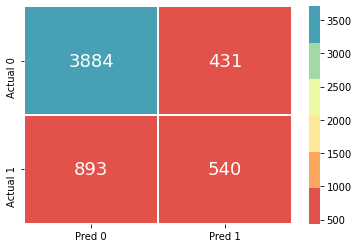

In [19]:
print('Accuracy %s' % round(accuracy_score(y_test, y_pred_dtree),3))           #accuracy score
print('F1-score %s' % round(f1_score(y_test, y_pred_dtree, average=None)[0],3), round(f1_score(y_test, y_pred_dtree, average=None)[1],3))   #f1 score
print(classification_report(y_test, y_pred_dtree))                    #classification report
#confusion matrix bellina:
conf_dtree = pd.DataFrame(confusion_matrix(y_test, y_pred_dtree), index = ["Actual 0", "Actual 1"], columns = ["Pred 0", "Pred 1"])
sn.heatmap(conf_dtree, annot=True, fmt='', annot_kws={"size": 18}, robust=True, cbar=True, cmap=sn.color_palette("Spectral"), linewidths=0.5)

[Text(484.375, 825.78125, 'city_development_index <= 0.625\nentropy = 0.81\nsamples = 13410\nvalue = [10066, 3344]'),
 Text(242.1875, 589.84375, 'company_size=1000-4999 <= 0.5\nentropy = 0.977\nsamples = 2431\nvalue = [998, 1433]'),
 Text(121.09375, 353.90625, 'experience <= 1.5\nentropy = 0.972\nsamples = 2245\nvalue = [904, 1341]'),
 Text(60.546875, 117.96875, '\n  (...)  \n'),
 Text(181.640625, 117.96875, '\n  (...)  \n'),
 Text(363.28125, 353.90625, 'experience <= 18.5\nentropy = 1.0\nsamples = 186\nvalue = [94, 92]'),
 Text(302.734375, 117.96875, '\n  (...)  \n'),
 Text(423.828125, 117.96875, '\n  (...)  \n'),
 Text(726.5625, 589.84375, 'relevent_experience=No relevent experience <= 0.5\nentropy = 0.667\nsamples = 10979\nvalue = [9068, 1911]'),
 Text(605.46875, 353.90625, 'city_development_index <= 0.768\nentropy = 0.576\nsamples = 7991\nvalue = [6896, 1095]'),
 Text(544.921875, 117.96875, '\n  (...)  \n'),
 Text(666.015625, 117.96875, '\n  (...)  \n'),
 Text(847.65625, 353.90625,

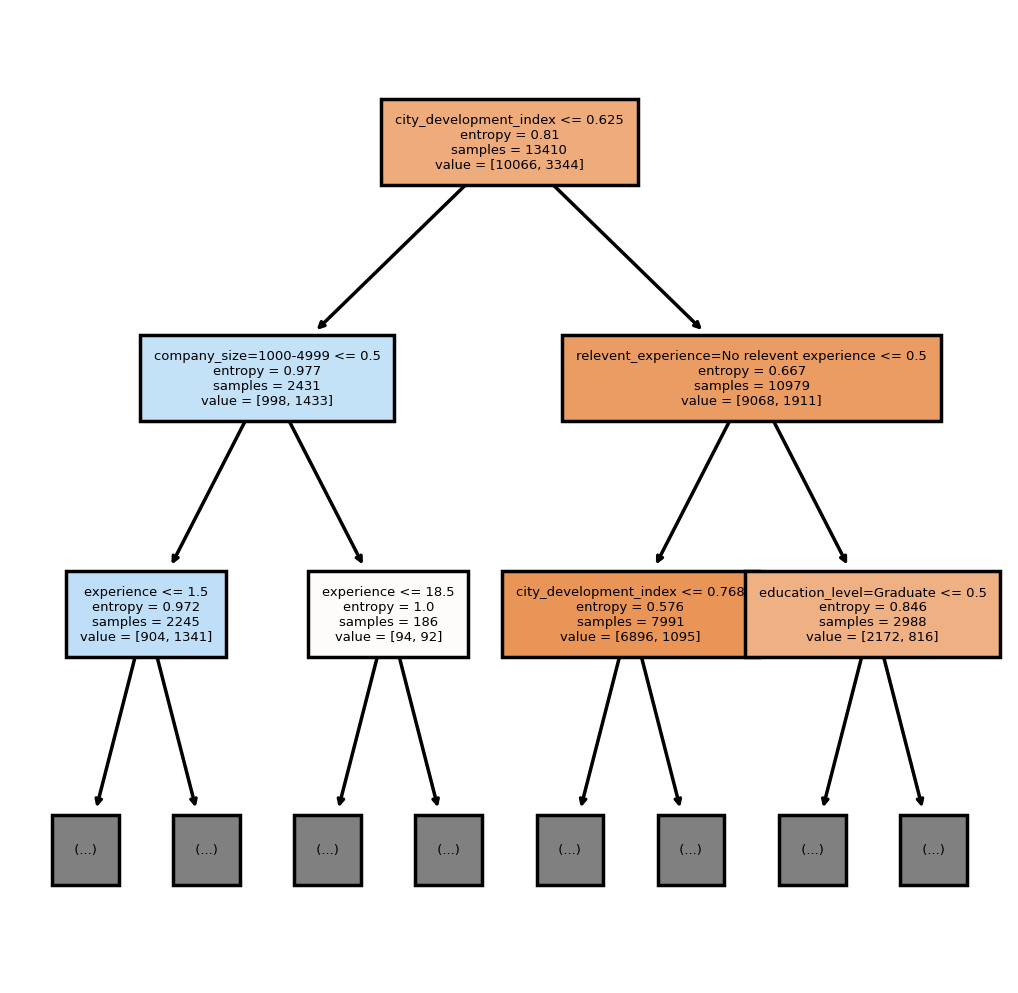

In [23]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5), dpi=250)
tree.plot_tree(dtree, filled=True, max_depth=2, fontsize=3.8, feature_names=attributes)

In [ ]:
plt.figure(figsize=(15,15))
plot_tree(dtree, filled=True, rounded=True, feature_names=attributes, max_depth=10, proportion=True, fontsize=18)
plt.show()

##Random Forest


Procedimento analogo a quello del Decision Tree ma con un RandomizedSearch su tanti Random Forest. 

In [24]:
rf_clf = RandomForestClassifier() #inizializzo il classificatore di cui vogliamo stimare i migliori parametri

In [25]:
rf_random_search = RandomizedSearchCV(rf_clf, param_distributions=param_list, #facciamo variare negli stessi parametri del dtree
                                   n_iter=100, cv=5, scoring='f1')
rf_random_search.fit(X_train, y_train)
rf_clf = rf_random_search.best_estimator_ #e prendiamo il migliore

In [29]:
report(rf_random_search.cv_results_, n_top=3) #visualizziamo top3

Model with rank: 1
Mean validation score: 0.447 (std: 0.010)
Parameters: {'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 17, 'criterion': 'entropy'}

Model with rank: 2
Mean validation score: 0.446 (std: 0.012)
Parameters: {'min_samples_split': 20, 'min_samples_leaf': 1, 'max_depth': 14, 'criterion': 'entropy'}

Model with rank: 3
Mean validation score: 0.443 (std: 0.020)
Parameters: {'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 16, 'criterion': 'entropy'}



In [30]:
rf_clf.fit(X_train, y_train)        #come al solito vogliamo adesso testare sul test set
y_pred_rf = rf_clf.predict(X_test)

Accuracy 0.7762700069589422
F1-score [0.86055086 0.43447669]
              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86      4315
         1.0       0.59      0.34      0.43      1433

    accuracy                           0.78      5748
   macro avg       0.70      0.63      0.65      5748
weighted avg       0.75      0.78      0.75      5748



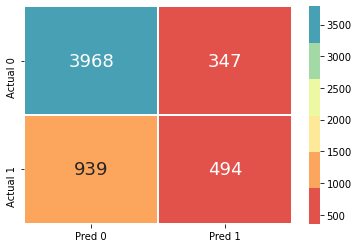

In [31]:
#soliti score per la model evaluation
print('Accuracy %s' % accuracy_score(y_test, y_pred_rf))
print('F1-score %s' % f1_score(y_test, y_pred_rf, average=None))
print(classification_report(y_test, y_pred_rf))

conf_rf = pd.DataFrame(confusion_matrix(y_test, y_pred_rf), index = ["Actual 0", "Actual 1"], columns = ["Pred 0", "Pred 1"])
sn.heatmap(conf_rf, annot=True, fmt='', annot_kws={"size": 18}, robust=True, cbar=True, cmap=sn.color_palette("Spectral"), linewidths=0.5)

#K-NN con variabili categoriche

Proviamo a fare diversi KNN scegliendo valori diversi di nearest neighbors per vedere qual è il numero che dà la migliore accuracy

In [32]:
df_test = pd.get_dummies(df_rf, prefix_sep='=') #df_rf era il dataframe che aveva le varabili categoriche, lo ritrasformiamo in dummies

In [33]:
attributes_cat = [col for col in df_test.columns if col != 'target']
X_cat = df_test[attributes_cat].values 
y = df_test['target']

X_train_cat, X_test_cat, y_train, y_test= train_test_split(X_cat, y, 
                                                    test_size=0.3, 
                                                    random_state=100, 
                                                    stratify=y)

Siccome abbiamo meno parametri potenzialmente rilevanti invece di fare un RandomSearch possiamo provarli tutti (forse si poteva usare il GridSearch invece del doppio ciclo for?). Vediamo quale KNN mi dà accuracy migliore variando k e variando i pesi.

In [34]:
k_accuracy_cat = {'uniform': [], 'distance': []} #creo un dizionario per comodità, per ogni tipo di peso (uniforme o distance-based) raccolgo la lista delle accuracy al variare di k
for k in range(20, 301, 20): #scelgo un range di valori per k
  for weight in ['uniform', 'distance']:
    knn_temp = KNeighborsClassifier(n_neighbors=k, weights=weight, metric='jaccard') 
    scores_temp = cross_val_score(knn_temp, X_train_cat, y_train, cv=5, scoring='f1') #al variare di weight e di k fammi un KNN con metrica jaccard
    #knn_temp.fit(X_train_cat, y_train)
    #y_temp_pred = knn_temp.predict(X_test_cat)
    k_accuracy_cat[weight].append(scores_temp.mean())
    

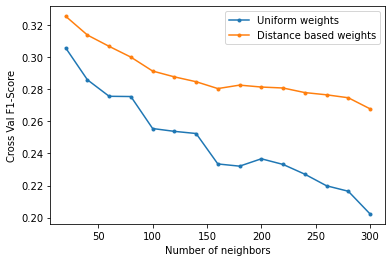

In [35]:
plt.plot(range(20, 301, 20), k_accuracy_cat['uniform'], marker='.', label='Uniform weights') #plottino dell'accuracy in funzione di k
plt.plot(range(20, 301, 20), k_accuracy_cat['distance'], marker='.', label='Distance based weights')
plt.xlabel('Number of neighbors')
plt.ylabel('Cross Val F1-Score')
plt.legend()
plt.show()

In [42]:
KNN1= KNeighborsClassifier(n_neighbors=20, weights='distance', metric='jaccard')

In [43]:
KNN1.fit(X_train_cat, y_train)
y_pred_knn1 = KNN1.predict(X_test_cat)

Accuracy 0.7418232428670842
F1-score [0.84046442 0.32360985]
              precision    recall  f1-score   support

         0.0       0.78      0.91      0.84      4315
         1.0       0.47      0.25      0.32      1433

    accuracy                           0.74      5748
   macro avg       0.63      0.58      0.58      5748
weighted avg       0.70      0.74      0.71      5748



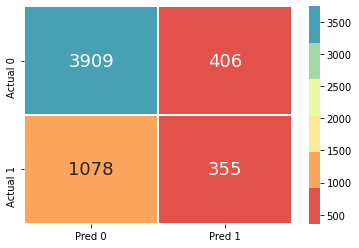

In [44]:
print('Accuracy %s' % accuracy_score(y_test, y_pred_knn1))
print('F1-score %s' % f1_score(y_test, y_pred_knn1, average=None))
print(classification_report(y_test, y_pred_knn1))

conf_KNN1 = pd.DataFrame(confusion_matrix(y_test, y_pred_knn1), index = ["Actual 0", "Actual 1"], columns = ["Pred 0", "Pred 1"])
sn.heatmap(conf_KNN1, annot=True, fmt='', annot_kws={"size": 18}, robust=True, cbar=True, cmap=sn.color_palette("Spectral"), linewidths=0.5)

#KNN con le 4 variabili continue

In [45]:
df_cont = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HR_Analytics/csv/HR_Analytics_KMeans.csv', delimiter=',', skipinitialspace=True)

In [46]:
df_cont['target'] = df_rf['target'].copy()

In [47]:
attributes_num = [col for col in df_cont.columns if col != 'target']
X_num = df[attributes_num].values
y = df_cont['target']

X2_train, X2_test, y2_train, y2_test = train_test_split(X_num, y, 
                                                    test_size=0.3, 
                                                    random_state=100, 
                                                    stratify=y)

scaler = MinMaxScaler()
scaler.fit(X2_train)
X2_train = scaler.transform(X2_train)
X2_test = scaler.transform(X2_test)

In [48]:
k_accuracy_num = {'uniform': [], 'distance': []}
for k in range(20, 301, 20): 
  for weight in ['uniform', 'distance']:
    knn_temp = KNeighborsClassifier(n_neighbors=k, weights=weight, metric='euclidean')
    scores_temp = cross_val_score(knn_temp, X2_train, y2_train, cv=5, scoring='f1')
    #y_temp_pred = knn_temp.predict(X2_test)
    k_accuracy_num[weight].append(scores_temp.mean())
    

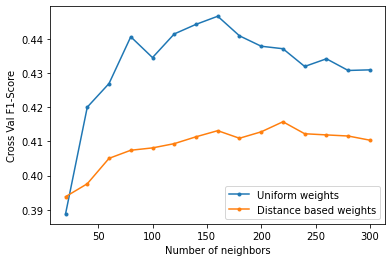

In [49]:
plt.plot(range(20, 301, 20), k_accuracy_num['uniform'], marker='.', label='Uniform weights')
plt.plot(range(20, 301, 20), k_accuracy_num['distance'], marker='.', label='Distance based weights')
plt.xlabel('Number of neighbors')
plt.ylabel('Cross Val F1-Score')
plt.legend()
plt.show()

Il picco è a k=160 con pesi uniformi


In [50]:
KNN2 = KNeighborsClassifier(n_neighbors=160, weights='uniform', metric='euclidean')
KNN2.fit(X2_train, y2_train)
y_pred_knn2 = KNN2.predict(X2_test)

In [ ]:
KNN2.kneighbors_graph()

<13410x13410 sparse matrix of type '<class 'numpy.float64'>'
	with 1743300 stored elements in Compressed Sparse Row format>

Accuracy 0.7743562978427279
F1-score [0.85940379 0.42888595]
              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86      4315
         1.0       0.58      0.34      0.43      1433

    accuracy                           0.77      5748
   macro avg       0.69      0.63      0.64      5748
weighted avg       0.75      0.77      0.75      5748



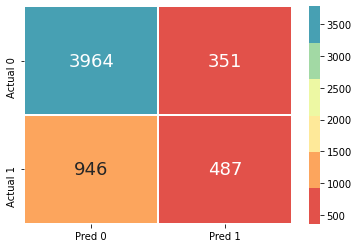

In [51]:
print('Accuracy %s' % accuracy_score(y_test, y_pred_knn2))
print('F1-score %s' % f1_score(y_test, y_pred_knn2, average=None))
print(classification_report(y_test, y_pred_knn2))

conf_KNN2 = pd.DataFrame(confusion_matrix(y_test, y_pred_knn2), index = ["Actual 0", "Actual 1"], columns = ["Pred 0", "Pred 1"])
sn.heatmap(conf_KNN2, annot=True, fmt='', annot_kws={"size": 18}, robust=True, cbar=True, cmap=sn.color_palette("Spectral"), linewidths=0.5)

#KNN MISTO

A questo punto è inutile continuare a insistere sui pesi non uniformi; per il dataframe con le variabili miste definiamo una distanza mista e valutiamo il KNN con n_neighbors=130 che era risultato il valore ottimale per il parametro per gli altri due tipi di KNN. Perché non valutare il numero ottimale di k a parte anche per questo? Perché ci mette otto anni e mezzo.

In [64]:
from scipy.spatial.distance import jaccard
from scipy.spatial.distance import euclidean
def mydist(x, y):
  d_cat = jaccard(x[4:37], y[4:37]) #distanza di jaccard sulle features categoriche
  d_cont = euclidean(x[0:4], y[0:4]) #distanza euclidea sulla features continue
  return d_cat + d_cont


In [65]:
df.head()

,city_development_index,experience,last_new_job,training_hours,gender=Female,gender=Male,gender=Other,relevent_experience=Has relevent experience,relevent_experience=No relevent experience,enrolled_university=Full time course,enrolled_university=Part time course,enrolled_university=no_enrollment,education_level=Graduate,education_level=High School,education_level=Masters,education_level=Phd,education_level=Primary School,major_discipline=Arts,major_discipline=Business Degree,major_discipline=Humanities,major_discipline=No Discipline,major_discipline=No Major,major_discipline=Other,major_discipline=STEM,company_size=10/49,company_size=100-500,company_size=1000-4999,company_size=10000+,company_size=50-99,company_size=500-999,company_size=5000-9999,company_size=<10,company_type=Early Stage Startup,company_type=Funded Startup,company_type=NGO,company_type=Other,company_type=Public Sector,company_type=Pvt Ltd,target
0,0.920,25.0,1,36,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1.0
1,0.776,15.0,5,47,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0.0
2,0.624,5.0,0,83,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0.0
3,0.789,0.5,0,52,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1.0
4,0.767,25.0,4,8,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0.0


In [66]:
attributes = [col for col in df.columns if col != 'target']
X = df[attributes].values 
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=100, 
                                                    stratify=y) #solita suddivisione in test e train che useremo per tutti i classificatori

In [67]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [68]:
KNN = KNeighborsClassifier(n_neighbors=160, metric=mydist, weights='uniform') #knn con pesi uniformi e metrica mista. 

In [69]:
KNN.fit(X_train, y_train)
y_pred_knn = KNN.predict(X_test)

In [70]:
target = pd.DataFrame({'KNN_prediction': y_pred_knn, 'Actual': y_test}) #la prediction di questa la salvo così in caso non deve runnare di nuovo
target.head(100)

,KNN_prediction,Actual
13668,0.0,0.0
9246,0.0,0.0
1694,1.0,0.0
2708,0.0,0.0
3299,0.0,0.0
...,...,...
11322,0.0,0.0
18825,0.0,1.0
6941,0.0,0.0
2554,0.0,0.0


In [71]:
target.to_csv('/content/drive/MyDrive/Colab Notebooks/HR_Analytics/y_pred_knn.csv', index=False)

In [73]:
df_knn = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HR_Analytics/y_pred_knn.csv', delimiter=',', skipinitialspace=True)
df_knn[df_knn['KNN_prediction']==1]

,KNN_prediction,Actual
2,1.0,0.0
29,1.0,1.0
34,1.0,1.0
37,1.0,1.0
38,1.0,1.0
...,...,...
5694,1.0,1.0
5699,1.0,1.0
5706,1.0,1.0
5728,1.0,1.0


Accuracy 0.7731384829505915
F1-score [0.86154173 0.37247353]
              precision    recall  f1-score   support

         0.0       0.80      0.94      0.86      4315
         1.0       0.60      0.27      0.37      1433

    accuracy                           0.77      5748
   macro avg       0.70      0.61      0.62      5748
weighted avg       0.75      0.77      0.74      5748



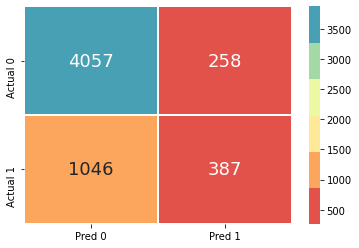

In [74]:
print('Accuracy %s' % accuracy_score(y_test, df_knn['KNN_prediction']))
print('F1-score %s' % f1_score(y_test, df_knn['KNN_prediction'], average=None))
print(classification_report(y_test, df_knn['KNN_prediction']))

conf_KNN = pd.DataFrame(confusion_matrix(y_test, df_knn['KNN_prediction']), index = ["Actual 0", "Actual 1"], columns = ["Pred 0", "Pred 1"] )
sn.heatmap(conf_KNN, annot=True, fmt='', annot_kws={"size": 18}, robust=True, cbar=True, cmap=sn.color_palette("Spectral"), linewidths=0.5)